In [1]:
import pandas as pd
import json

df_channels = pd.read_csv('df_channels_en.tsv', sep='\t')
print(df_channels.head())
print(df_channels.info())

     category_cc   join_date                   channel  \
0         Gaming  2010-04-29  UC-lHJZR3Gqxm24_Vd_AJ5Yw   
1      Education  2006-09-01  UCbCmjCuTUZos6Inko4u57UQ   
2  Entertainment  2006-09-20  UCpEhnqL0y41EpW2TvWAHD7Q   
3  Howto & Style  2016-11-15  UC295-Dw_tDNtZXFeAPAW6Aw   
4         Sports  2007-05-11  UCJ5v_MCY6GNUBTO8-D3XoAg   

                   name_cc  subscribers_cc  videos_cc  subscriber_rank_sb  \
0                PewDiePie       101000000       3956                 3.0   
1  Cocomelon - Nursery ...        60100000        458                 7.0   
2                SET India        56018869      32661                 8.0   
3          5-Minute Crafts        60600000       3591                 9.0   
4                      WWE        48400000      43421                11.0   

   weights  
0    2.087  
1    2.087  
2    2.087  
3    2.087  
4    2.087  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136470 entries, 0 to 136469
Data columns (total 8 columns):


In [2]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

df_metadata = load_jsonl('metadata_filtered.jsonl')

df_metadata.rename(columns={'channel_id': 'channel'}, inplace=True)

print(df_metadata.head())
print(df_metadata.info())

  categories                   channel                  crawl_date  \
0     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:33.001044   
1     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:33.563584   
2     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:36.350067   
3     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:36.930863   
4     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:39.777410   

  description  dislike_count   display_id  duration  like_count  \
0                        6.0  iWbFNJaaHrw       270        47.0   
1                        8.0  MRaGK43Ux-k       109        52.0   
2                        4.0  -91qrjpgRw0        58        26.0   
3                        8.0  nq9_WZXjjCI        71        25.0   
4                       24.0  Kh-s-TEnqWY      7508        43.0   

                                                tags  \
0  video,games,retrogamer3,ed,findlay,Trump,Ameri...   
1  video,games,retrogamer3,ed,findlay,America's R...   
2  video

In [3]:
df_channels.dropna(subset=['channel'], inplace=True)
df_metadata.fillna({'description': '', 'tags': '', 'keywords': ''}, inplace=True)


# remove duplicates
df_channels.drop_duplicates(subset=['channel'], inplace=True)
df_metadata.drop_duplicates(subset=['display_id'], inplace=True)

df_channels['channel'] = df_channels['channel'].str.upper()
df_metadata['channel'] = df_metadata['channel'].str.upper()


# merge statistics with metadata
df_combined = pd.merge(df_metadata, df_channels, left_on='channel', right_on='channel', how='left')

# check the result after merging
print(len(df_metadata))
print(len(df_combined))
print(df_combined.head(1))


447616
447616
  categories                   channel                  crawl_date  \
0     Gaming  UCZWM1-4XF7AHXVUTKHCM1UW  2019-11-17 06:28:33.001044   

  description  dislike_count   display_id  duration  like_count  \
0                        6.0  iWbFNJaaHrw       270        47.0   

                                                tags  \
0  video,games,retrogamer3,ed,findlay,Trump,Ameri...   

                                   title          upload_date  view_count  \
0  America's Retribution Term 2 Launched  2019-05-08 00:00:00       445.0   

  keywords category_cc   join_date     name_cc  subscribers_cc  videos_cc  \
0   trump       Gaming  2008-07-18  Ed Findlay           11884        311   

   subscriber_rank_sb  weights  
0            857247.0  14.1935  


In [4]:
print(df_combined.columns)

Index(['categories', 'channel', 'crawl_date', 'description', 'dislike_count',
       'display_id', 'duration', 'like_count', 'tags', 'title', 'upload_date',
       'view_count', 'keywords', 'category_cc', 'join_date', 'name_cc',
       'subscribers_cc', 'videos_cc', 'subscriber_rank_sb', 'weights'],
      dtype='object')


In [5]:
import re

# define a function to extract keywords from the description
conspiracy_definitions = {
    "conspiracy_theories": [
        {
            "name": "Deep State",
            "description": "Refers to a hidden powerful faction within the government allegedly working to undermine Trump and his supporters."
        },
        {
            "name": "Election Fraud",
            "description": "Claims of widespread election fraud, especially in the 2020 presidential election, focusing on alleged issues with mail-in ballots."
        },
        {
            "name": "QAnon",
            "description": "While not explicitly endorsed, Trump has shown indirect support for followers of QAnon, a conspiracy about a deep-rooted cabal involved in child trafficking and satanic rituals."
        },
        {
            "name": "Missing Emails",
            "description": "Refers to the 2016 scandal involving Hillary Clinton’s deleted emails, which Trump frequently highlighted."
        },
        {
            "name": "Biden Family Scandal",
            "description": "Claims of corruption within the Biden family, particularly involving Hunter Biden’s business dealings and alleged exploitation of Biden’s influence."
        },
        {
            "name": "Climate Change Hoax",
            "description": "Skepticism toward climate change, suggesting it's a 'hoax' promoted by global elites for profit."
        }
    ]
}

# print the conspiracy definitions
conspiracy_keywords = {
    "Deep State": ["deepstate", "deep state", "government faction", "shadow government", "hidden government"],
    "Election Fraud": ["election fraud", "vote fraud", "mail-in ballots", "voter suppression", "rigged election"],
    "QAnon": ["qanon", "cabal", "child trafficking", "satanic rituals", "deep-rooted cabal", "Q movement"],
    "Missing Emails": ["missing emails", "deleted emails", "clinton emails", "email scandal", "email leak"],
    "Biden Family Scandal": ["biden family scandal", "hunter biden", "biden corruption", "biden business dealings", "biden influence"],
    "Climate Change Hoax": ["climate change hoax", "global elites", "climate profit", "false climate", "climate deception"]
}

import json
print("\nconspiracy_keywords:")
print(json.dumps(conspiracy_keywords, indent=2, ensure_ascii=False))


conspiracy_keywords:
{
  "Deep State": [
    "deepstate",
    "deep state",
    "government faction",
    "shadow government",
    "hidden government"
  ],
  "Election Fraud": [
    "election fraud",
    "vote fraud",
    "mail-in ballots",
    "voter suppression",
    "rigged election"
  ],
  "QAnon": [
    "qanon",
    "cabal",
    "child trafficking",
    "satanic rituals",
    "deep-rooted cabal",
    "Q movement"
  ],
  "Missing Emails": [
    "missing emails",
    "deleted emails",
    "clinton emails",
    "email scandal",
    "email leak"
  ],
  "Biden Family Scandal": [
    "biden family scandal",
    "hunter biden",
    "biden corruption",
    "biden business dealings",
    "biden influence"
  ],
  "Climate Change Hoax": [
    "climate change hoax",
    "global elites",
    "climate profit",
    "false climate",
    "climate deception"
  ]
}


In [ ]:

# check if a text contains any of the conspiracy
def detect_conspiracy_types(row, keywords_dict):
    # combine the title, description, and tags into a single text
    text = ' '.join([str(row['title']), str(row['description']), str(row['tags'])]).lower()
    detected = {}
    for theory, keywords in keywords_dict.items():
        # create a regular expression pattern to match any of the keywords
        pattern = re.compile('|'.join([re.escape(word) for word in keywords]), re.IGNORECASE)
        if pattern.search(text):
            detected[theory] = 1
            continue
        else:
            detected[theory] = 0
    return pd.Series(detected)


In [7]:
# Initialize list to store records with conspiracy keywords
df_combined = df_combined.fillna({'title': '', 'description': '', 'tags': '', 'keywords': ''})

conspiracy_detection = df_combined.apply(lambda row: detect_conspiracy_types(row, conspiracy_keywords), axis=1)
df_combined_with_conspiracy = pd.concat([df_combined, conspiracy_detection], axis=1)

# add a column to indicate if any conspiracy keyword was detected
df_combined_with_conspiracy['is_conspiracy'] = df_combined_with_conspiracy[list(conspiracy_keywords.keys())].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# check the result
print("\nconspiracy_detection:")
print(df_combined_with_conspiracy[['title', 'is_conspiracy'] + list(conspiracy_keywords.keys())].head())

print("\nconspiracy_detection_overall:")
print(df_combined_with_conspiracy['is_conspiracy'].value_counts())




conspiracy_detection:
                                     title  is_conspiracy  Deep State  \
0    America's Retribution Term 2 Launched              0           0   
1      America's Retribution Term 2 promo!              0           0   
2  The last mini boss is done. The fuhrer.              0           0   
3          Elizabeth Warren Boss Finished!              0           0   
4           America's Retribution -Stream-              0           0   

   Election Fraud  QAnon  Missing Emails  Biden Family Scandal  \
0               0      0               0                     0   
1               0      0               0                     0   
2               0      0               0                     0   
3               0      0               0                     0   
4               0      0               0                     0   

   Climate Change Hoax  
0                    0  
1                    0  
2                    0  
3                    0  
4               

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# Remove zero or negative values to avoid issues with the logarithmic scale
view_counts = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]['view_count']
view_counts = view_counts[view_counts > 0]


# Like/Dislike ratio distribution for conspiracy videos
# Avoid division by zero by replacing 0 dislikes with a small number (or filtering them out)
like_count = df_combined_with_conspiracy['like_count']
dislike_count = df_combined_with_conspiracy['dislike_count']
dislike_count = dislike_count.replace(0, np.nan)  # Replace 0 dislikes with NaN to avoid division issues

# Calculate ratio, dropping NaNs (resulting from zero dislikes)
df_combined_with_conspiracy['like_dislike_ratio'] = like_count / dislike_count
ratio_data = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]['like_dislike_ratio'].dropna()


In [9]:
# get non-conspiracy records

pd.set_option('display.float_format', '{:,.2f}'.format)
# # Display the first few rows of the DataFrame

non_conspiracy_df = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 0]

print('without conspiracy')
print(non_conspiracy_df['view_count'].describe())
print('with conspiracy')
print(df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]['view_count'].describe())


without conspiracy
count       438,502.00
mean         63,287.61
std         794,433.20
min               0.00
25%             712.00
50%           3,983.00
75%          21,288.00
max     254,265,977.00
Name: view_count, dtype: float64
with conspiracy
count        9,082.00
mean        46,751.37
std        290,382.99
min              2.00
25%          2,433.25
50%          8,567.50
75%         30,199.50
max     21,382,840.00
Name: view_count, dtype: float64


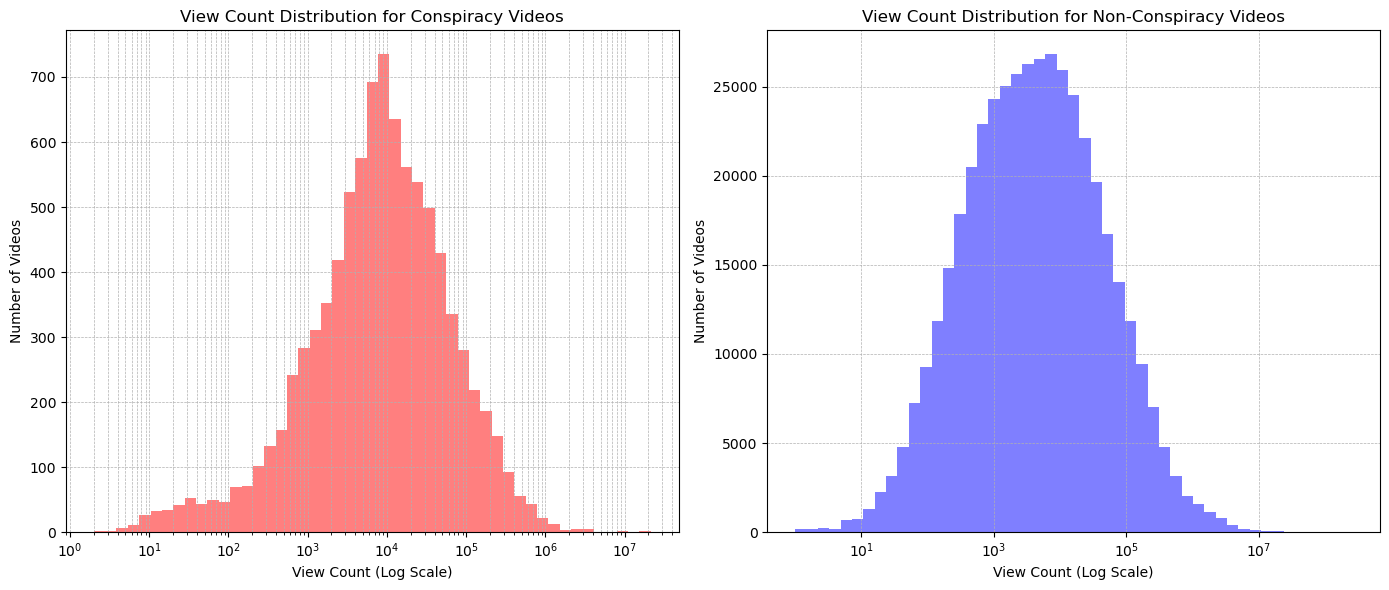

<Figure size 1400x1200 with 0 Axes>

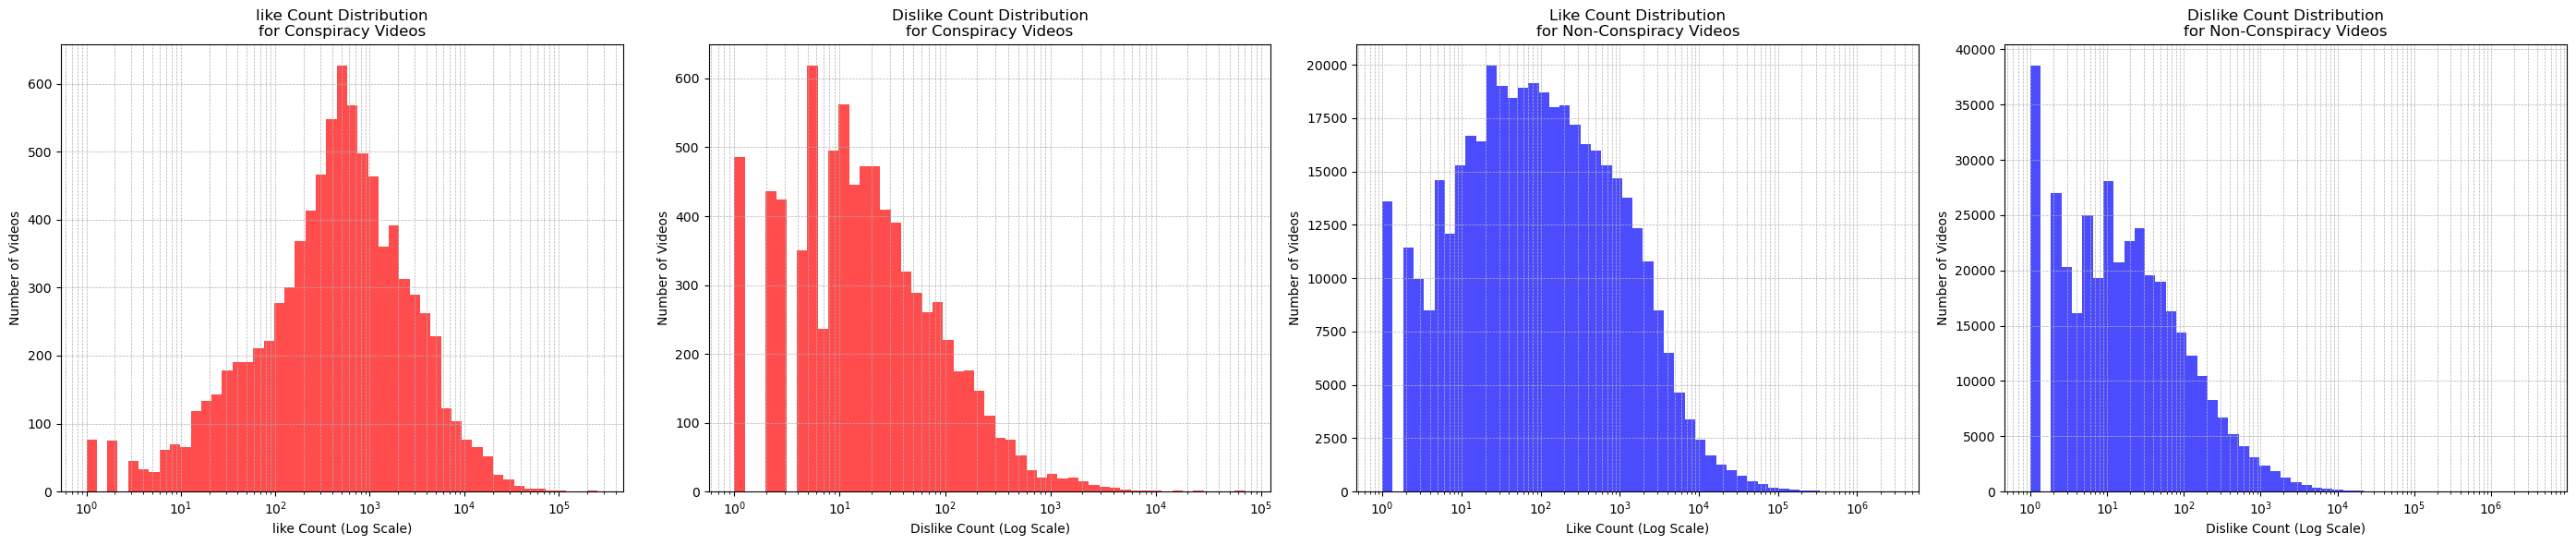

/tmp/ipykernel_2093939/3989107312.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conspiracy_df['like_dislike_ratio'] = like_count_conspiracy / dislike_count_conspiracy
/tmp/ipykernel_2093939/3989107312.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_conspiracy_df['like_dislike_ratio'] = like_count_non_conspiracy / dislike_count_non_conspiracy


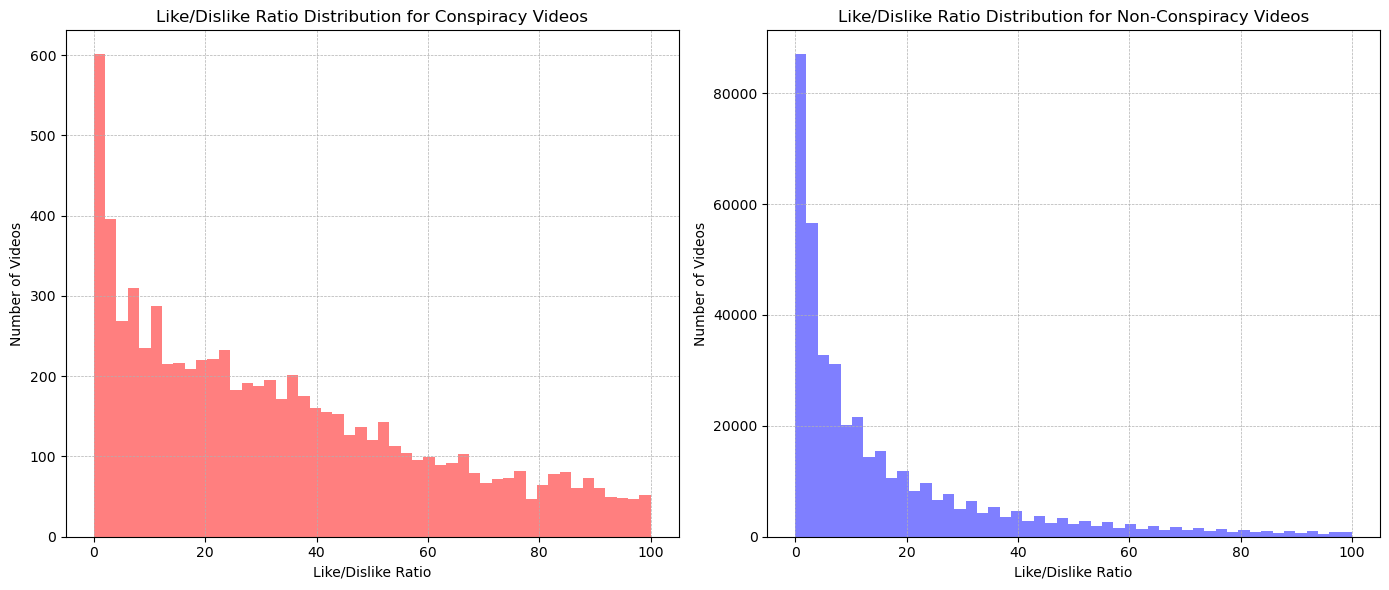

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Filter conspiracy and non-conspiracy DataFrames
conspiracy_df = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]
non_conspiracy_df = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 0]

# Plot 1: View Count Distribution (Log Scale)
plt.figure(figsize=(14, 6))

# Conspiracy
plt.subplot(1, 2, 1)
view_counts_conspiracy = conspiracy_df['view_count']
view_counts_conspiracy = view_counts_conspiracy[view_counts_conspiracy > 0]
plt.hist(view_counts_conspiracy, bins=np.logspace(np.log10(view_counts_conspiracy.min()), np.log10(view_counts_conspiracy.max()), 50), alpha=0.5, color='r')
plt.xscale('log')
plt.xlabel('View Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('View Count Distribution for Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Non-Conspiracy
plt.subplot(1, 2, 2)
view_counts_non_conspiracy = non_conspiracy_df['view_count']
view_counts_non_conspiracy = view_counts_non_conspiracy[view_counts_non_conspiracy > 0]
plt.hist(view_counts_non_conspiracy, bins=np.logspace(np.log10(view_counts_non_conspiracy.min()), np.log10(view_counts_non_conspiracy.max()), 50), alpha=0.5, color='b')
plt.xscale('log')
plt.xlabel('View Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('View Count Distribution for Non-Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Plot 2: Like vs Dislike Scatter Plot (Log Scale)
plt.figure(figsize=(14, 12))
# Plotting Histograms
import matplotlib.pyplot as plt
import numpy as np

# Data Preparation
# Like Counts for Conspiracy Videos
like_counts_conspiracy = conspiracy_df['like_count']
like_counts_conspiracy = like_counts_conspiracy[like_counts_conspiracy > 0]

# Dislike Counts for Conspiracy Videos
dislike_counts_conspiracy = conspiracy_df['dislike_count']
dislike_counts_conspiracy = dislike_counts_conspiracy[dislike_counts_conspiracy > 0]

# Like Counts for Non-Conspiracy Videos
like_counts_non_conspiracy = non_conspiracy_df['like_count']
like_counts_non_conspiracy = like_counts_non_conspiracy[like_counts_non_conspiracy > 0]

# Dislike Counts for Non-Conspiracy Videos
dislike_counts_non_conspiracy = non_conspiracy_df['dislike_count']
dislike_counts_non_conspiracy = dislike_counts_non_conspiracy[dislike_counts_non_conspiracy > 0]

# Adjust the figure size to accommodate four plots in one row
plt.figure(figsize=(28, 6))

# Subplot 1: Like Counts for Conspiracy Videos
plt.subplot(1, 4, 1)
plt.hist(
    like_counts_conspiracy,
    bins=np.logspace(
        np.log10(like_counts_conspiracy.min()),
        np.log10(like_counts_conspiracy.max()),
        50
    ),
    alpha=0.7,
    color='red'
)
plt.xscale('log')
plt.xlabel('like Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('like Count Distribution\nfor Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Subplot 2: Dislike Counts for Conspiracy Videos
plt.subplot(1, 4, 2)
plt.hist(
    dislike_counts_conspiracy,
    bins=np.logspace(
        np.log10(dislike_counts_conspiracy.min()),
        np.log10(dislike_counts_conspiracy.max()),
        50
    ),
    alpha=0.7,
    color='red'
)
plt.xscale('log')
plt.xlabel('Dislike Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('Dislike Count Distribution\nfor Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Subplot 3: Like Counts for Non-Conspiracy Videos
plt.subplot(1, 4, 3)
plt.hist(
    like_counts_non_conspiracy,
    bins=np.logspace(
        np.log10(like_counts_non_conspiracy.min()),
        np.log10(like_counts_non_conspiracy.max()),
        50
    ),
    alpha=0.7,
    color='blue'
)
plt.xscale('log')
plt.xlabel('Like Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('Like Count Distribution\nfor Non-Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Subplot 4: Dislike Counts for Non-Conspiracy Videos
plt.subplot(1, 4, 4)
plt.hist(
    dislike_counts_non_conspiracy,
    bins=np.logspace(
        np.log10(dislike_counts_non_conspiracy.min()),
        np.log10(dislike_counts_non_conspiracy.max()),
        50
    ),
    alpha=0.7,
    color='blue'
)
plt.xscale('log')
plt.xlabel('Dislike Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('Dislike Count Distribution\nfor Non-Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# Plot 3: Like/Dislike Ratio Distribution (Log Scale)
plt.figure(figsize=(14, 6))


# Conspiracy
plt.subplot(1, 2, 1)
like_count_conspiracy = conspiracy_df['like_count'].replace(0,0.25)
dislike_count_conspiracy = conspiracy_df['dislike_count'].replace(0, 0.25)
conspiracy_df['like_dislike_ratio'] = like_count_conspiracy / dislike_count_conspiracy
# conspiracy_df.loc[conspiracy_df['like_dislike_ratio'] < 1, 'like_dislike_ratio'] = (dislike_count_conspiracy / like_count_conspiracy) - 1
ratio_data_conspiracy = conspiracy_df['like_dislike_ratio'].dropna()
plt.hist(ratio_data_conspiracy, bins=np.linspace(0, 100, 50), alpha=0.5, color='r')
plt.xlabel('Like/Dislike Ratio')
plt.ylabel('Number of Videos')
plt.title('Like/Dislike Ratio Distribution for Conspiracy Videos')
plt.grid(True, linestyle='--', linewidth=0.5)

# Non-Conspiracy
plt.subplot(1, 2, 2)
like_count_non_conspiracy = non_conspiracy_df['like_count'].replace(0,0.25)
dislike_count_non_conspiracy = non_conspiracy_df['dislike_count'].replace(0, 0.25)
non_conspiracy_df['like_dislike_ratio'] = like_count_non_conspiracy / dislike_count_non_conspiracy
# non_conspiracy_df.loc[non_conspiracy_df['like_dislike_ratio'] < 1, 'like_dislike_ratio'] = (dislike_count_non_conspiracy / like_count_non_conspiracy) - 1
ratio_data_non_conspiracy = non_conspiracy_df['like_dislike_ratio'].dropna()
plt.hist(ratio_data_non_conspiracy, bins=np.linspace(0, 100, 50), alpha=0.5, color='b')
plt.xlabel('Like/Dislike Ratio')
plt.ylabel('Number of Videos')
plt.title('Like/Dislike Ratio Distribution for Non-Conspiracy Videos')
plt.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


In [51]:
print(conspiracy_df['like_dislike_ratio'].describe())

count   8,854.00
mean       62.45
std       115.18
min         0.04
25%        13.25
50%        35.69
75%        73.74
max     3,020.00
Name: like_dislike_ratio, dtype: float64


: 

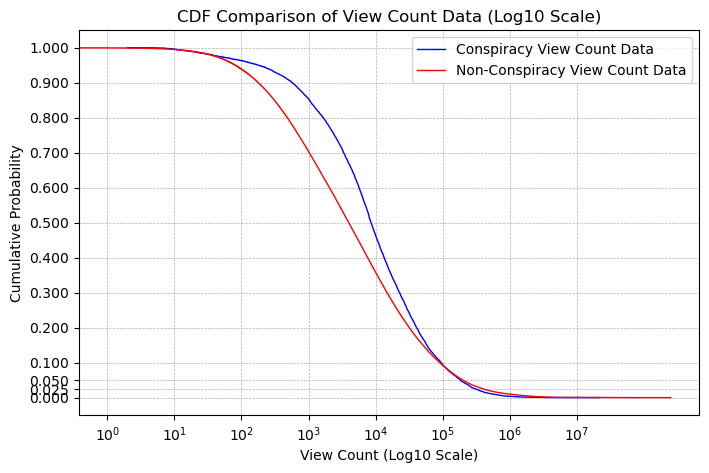

In [11]:
view_data1 = np.sort(conspiracy_df['view_count'].dropna())
view_cdf1 = 1 - np.arange(1, len(view_data1) + 1) / len(view_data1)

view_data2 = np.sort(non_conspiracy_df['view_count'].dropna())
view_cdf2 = 1 - np.arange(1, len(view_data2) + 1) / len(view_data2)
# conspiracy_data = [{"x": float(x), "y": float(y)} for x, y in zip(view_data1, view_cdf1)]
# non_conspiracy_data = [{"x": float(x), "y": float(y)} for x, y in zip(view_data2, view_cdf2)]

plt.figure(figsize=(8, 5))
plt.plot(view_data1, view_cdf1, label='Conspiracy View Count Data', linewidth=1, color='blue')
plt.plot(view_data2, view_cdf2, label='Non-Conspiracy View Count Data', linewidth=1, color='red')
plt.xscale('log')
plt.title('CDF Comparison of View Count Data (Log10 Scale)')
plt.xlabel('View Count (Log10 Scale)')
xticks = [10**i for i in range(0, 8)]  # 10^0 to 10^7
plt.xticks(xticks, labels=[f"$10^{i}$" for i in range(0, 8)])
plt.ylabel('Cumulative Probability')
plt.yticks([0.0, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [53]:
import plotly.graph_objects as go
import numpy as n
fig = go.Figure()

# Add non-conspiracy CDF
fig.add_trace(go.Scatter(
    x=view_data2,
    y=view_cdf2,
    mode='lines',
    name='Non-Conspiracy View Count Data',
    line=dict(color='red')
))

# Add conspiracy CDF
fig.add_trace(go.Scatter(
    x=view_data1,
    y=view_cdf1,
    mode='lines',
    name='Conspiracy View Count Data',
    line=dict(color='blue')
))

# Update layout
fig.update_layout(
    title="View count comparison",
    xaxis=dict(
        title="View Count",
        type="log",  # Log scale for x-axis
        title_font=dict(size=14),
        tickformat=","
    ),
    yaxis=dict(
        title="CCDF",
        title_font=dict(size=14)
    ),
    legend=dict(
        x=0.75, y=0.95
    ),

)

# Export to HTML
output_file = "plotly_view_count_comparison.html"
fig.write_html(output_file)

print(f"HTML file saved to: {output_file}")

HTML file saved to: plotly_view_count_comparison.html


: 

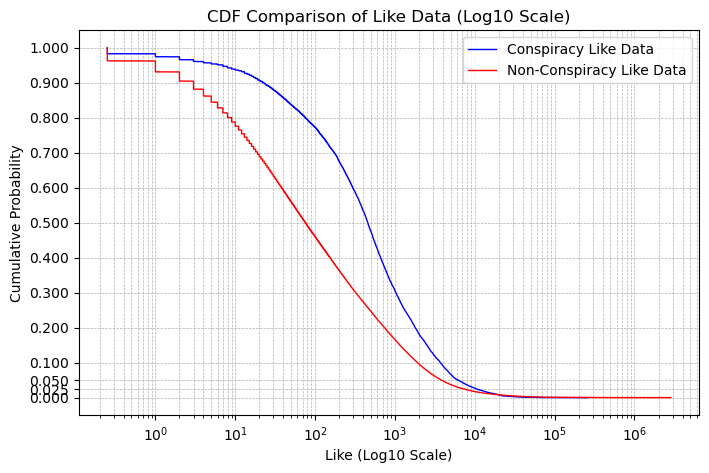

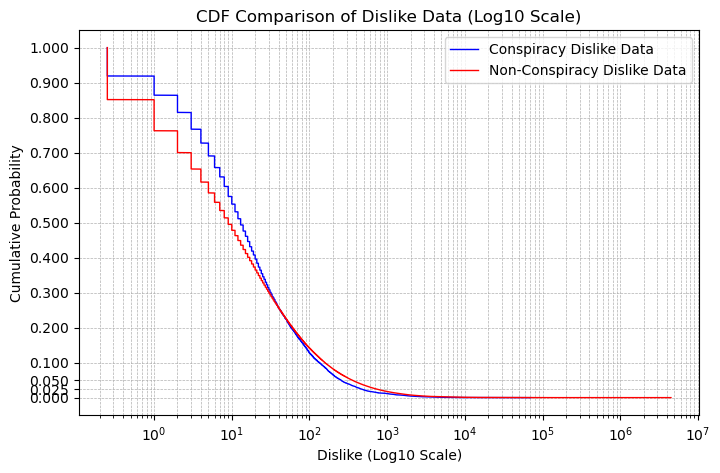

In [ ]:
# like CCDF
like_data1 = np.sort(conspiracy_df['like_count'].dropna().replace(0, 0.25))
like_cdf1 = 1 - np.arange(1, len(like_data1) + 1) / len(like_data1)

like_data2 = np.sort(non_conspiracy_df['like_count'].dropna().replace(0, 0.25))
like_cdf2 = 1 - np.arange(1, len(like_data2) + 1) / len(like_data2)
# conspriracy_like_data = [{"x": float(x), "y": float(y)} for x, y in zip(like_data1, like_cdf1)]
# non_conspiracy_like_data = [{"x": float(x), "y": float(y)} for x, y in zip(like_data2, like_cdf2)]


# dislike CCDF
dislike_data1 = np.sort(conspiracy_df['dislike_count'].dropna().replace(0, 0.25))
dislike_cdf1 = 1 - np.arange(1, len(dislike_data1) + 1) / len(dislike_data1)

dislike_data2 = np.sort(non_conspiracy_df['dislike_count'].dropna().replace(0, 0.25))
dislike_cdf2 = 1 - np.arange(1, len(dislike_data2) + 1) / len(dislike_data2)
# conspiracy_dislike_data = [{"x": float(x), "y": float(y)} for x, y in zip(dislike_data1, dislike_cdf1)]
# non_conspiracy_dislike_data = [{"x": float(x), "y": float(y)} for x, y in zip(dislike_data2, dislike_cdf2)]

# 绘制 like 的 CDF
plt.figure(figsize=(8, 5))
plt.plot(like_data1, like_cdf1, label='Conspiracy Like Data', linewidth=1, color='blue')
plt.plot(like_data2, like_cdf2, label='Non-Conspiracy Like Data', linewidth=1, color='red')
plt.xscale('log')
plt.title('CDF Comparison of Like Data (Log10 Scale)')
plt.xlabel('Like (Log10 Scale)')
plt.ylabel('Cumulative Probability')
plt.yticks([0.0, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# 绘制 dislike 的 CDF
plt.figure(figsize=(8, 5))
plt.plot(dislike_data1, dislike_cdf1, label='Conspiracy Dislike Data', linewidth=1, color='blue')
plt.plot(dislike_data2, dislike_cdf2, label='Non-Conspiracy Dislike Data', linewidth=1, color='red')
plt.xscale('log')
plt.title('CDF Comparison of Dislike Data (Log10 Scale)')
plt.xlabel('Dislike (Log10 Scale)')
plt.ylabel('Cumulative Probability')
plt.yticks([0.0, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [61]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots

# 数据预处理函数
def remove_outliers(data):
    upper_bound = 10000
    lower_bound = 0.01
    return data[(data >= lower_bound) & (data <= upper_bound)]

def compute_ccdf(data):
    sorted_data = np.sort(data)
    ccdf = 1 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ccdf

# 计算 CCDF
like_x1, like_y1 = compute_ccdf(like_data1)
like_x2, like_y2 = compute_ccdf(like_data2)
dislike_data1 = remove_outliers(dislike_data1)
dislike_data2 = remove_outliers(dislike_data2)
dislike_data1 = np.sort(dislike_data1)
dislike_data2 = np.sort(dislike_data2)
dislike_x1, dislike_y1 = compute_ccdf(dislike_data1)
dislike_x2, dislike_y2 = compute_ccdf(dislike_data2)

# 创建左侧的 Like CCDF 图
fig_like = go.Figure()
fig_like.add_trace(go.Scatter(
    x=like_x1,
    y=like_y1,
    mode='lines',
    name='Like (Conspiracy)',
    line=dict(color='blue')
))
fig_like.add_trace(go.Scatter(
    x=like_x2,
    y=like_y2,
    mode='lines',
    name='Like (Non-Conspiracy)',
    line=dict(color='red')
))

# 创建右侧的 Dislike CCDF 图
fig_dislike = go.Figure()
fig_dislike.add_trace(go.Scatter(
    x=dislike_x1,
    y=dislike_y1,
    mode='lines',
    name='Dislike (Conspiracy)',
    line=dict(color='blue')
))
fig_dislike.add_trace(go.Scatter(
    x=dislike_x2,
    y=dislike_y2,
    mode='lines',
    name='Dislike (Non-Conspiracy)',
    line=dict(color='red')
))

# 创建两个并排的子图
fig = make_subplots(rows=1, cols=2, subplot_titles=("Like CCDF Comparison", "Dislike CCDF Comparison"))
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=12)
# 添加 Like 和 Dislike CCDF 图
for trace in fig_like.data:
    fig.add_trace(trace, row=1, col=1)
for trace in fig_dislike.data:
    fig.add_trace(trace, row=1, col=2)

# 设置两个子图的 x 轴为对数刻度
fig.update_xaxes(
    title_text="Like Count",
    type="log",  # 设置为对数刻度
    row=1, col=1
)
fig.update_xaxes(
    title_text="Dislike Count",
    type="log",  # 设置为对数刻度
    row=1, col=2
)

# 设置 y 轴标题
fig.update_yaxes(
    title_text="CCDF (Probability)",
    row=1, col=1
)
fig.update_yaxes(
    row=1, col=2
)

# 更新布局
fig.update_layout(
    title="Like and Dislike CCDF Comparison (Log Scale)"
)

# 导出为 HTML 文件
output_file = "ccdf_like_dislike_side_by_side.html"
fig.write_html(output_file)

print(f"HTML file saved to: {output_file}")


HTML file saved to: ccdf_like_dislike_side_by_side.html


: 

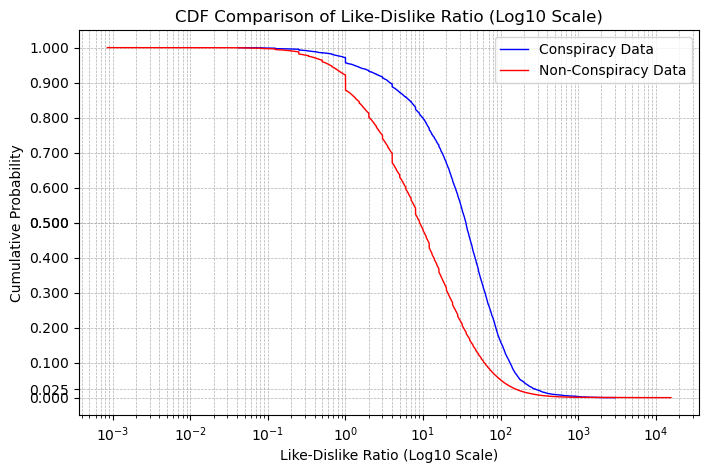

In [13]:
data1 = np.sort(conspiracy_df['like_dislike_ratio'].dropna())
cdf1 = 1- np.arange(1, len(data1) + 1) / len(data1)

data2 = np.sort(non_conspiracy_df['like_dislike_ratio'].dropna())
cdf2 = 1- np.arange(1, len(data2) + 1) / len(data2)
# conspiracy_data_like_dislike_ratio = [{"x": float(x), "y": float(y)} for x, y in zip(data1, cdf1)]
# non_conspiracy_data_like_dislike_ratio = [{"x": float(x), "y": float(y)} for x, y in zip(data2, cdf2)]

# plot CCDF of like-dislike ratio
plt.figure(figsize=(8, 5))

plt.plot(data1, cdf1, label='Conspiracy Data', linewidth=1, color='blue')

plt.plot(data2, cdf2, label='Non-Conspiracy Data', linewidth=1, color='red')

plt.xscale('log') 
plt.title('CDF Comparison of Like-Dislike Ratio (Log10 Scale)')
plt.xlabel('Like-Dislike Ratio (Log10 Scale)')
plt.ylabel('Cumulative Probability')
# plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 1.0])
plt.yticks([0.0, 0.025, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [57]:
import plotly.graph_objects as go
import numpy as n
fig = go.Figure()

# Add non-conspiracy CDF
fig.add_trace(go.Scatter(
    x=data2,
    y=cdf2,
    mode='lines',
    name='Non-Conspiracy ratio Data',
    line=dict(color='red')
))

# Add conspiracy CDF
fig.add_trace(go.Scatter(
    x=data1,
    y=cdf1,
    mode='lines',
    name='Conspiracy ratio Data',
    line=dict(color='blue')
))

# Update layout
fig.update_layout(
    title="Like-Dislike ratio comparison",
    xaxis=dict(
        title="Like-Dislike ratio",
        type="log",  # Log scale for x-axis
        title_font=dict(size=14),
        tickformat=","
    ),
    yaxis=dict(
        title="CCDF",
        title_font=dict(size=14)
    ),
    legend=dict(
        x=0.75, y=0.95
    ),

)

# Export to HTML
output_file = "plotly_like_dislike_ratio_comparison.html"
fig.write_html(output_file)

print(f"HTML file saved to: {output_file}")

HTML file saved to: plotly_like_dislike_ratio_comparison.html


: 

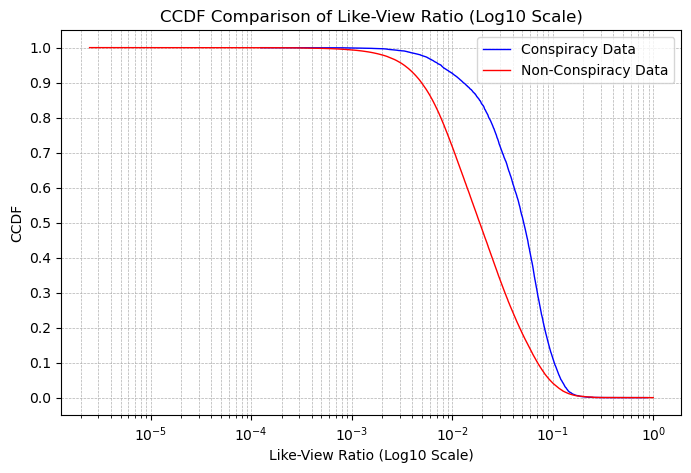

<Figure size 640x480 with 0 Axes>

In [73]:
like_view_ratio1 = conspiracy_df['like_count'].dropna().replace(0, 0.25) / conspiracy_df['view_count'].dropna().replace(0, 1)
like_view_ratio2 = non_conspiracy_df['like_count'].dropna().replace(0, 0.25) / non_conspiracy_df['view_count'].dropna().replace(0, 1)
like_view_ratio1 = np.clip(like_view_ratio1, 1e-6, 1).dropna()
like_view_ratio2 = np.clip(like_view_ratio2, 1e-6, 1).dropna()

like_view_ratio1 = np.sort(like_view_ratio1)
like_view_ratio2 = np.sort(like_view_ratio2)

like_view_ratio_cdf1 = 1 - np.arange(1, len(like_view_ratio1) + 1) / len(like_view_ratio1)
like_view_ratio_cdf2 = 1 - np.arange(1, len(like_view_ratio2) + 1) / len(like_view_ratio2)

# plot CCDF of like-view ratio
plt.figure(figsize=(8, 5))

plt.plot(like_view_ratio1, like_view_ratio_cdf1, label='Conspiracy Data', linewidth=1, color='blue')
plt.plot(like_view_ratio2, like_view_ratio_cdf2, label='Non-Conspiracy Data', linewidth=1, color='red')

plt.xscale('log')
plt.title('CCDF Comparison of Like-View Ratio (Log10 Scale)')
plt.xlabel('Like-View Ratio (Log10 Scale)')
plt.ylabel('CCDF')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()
plt.savefig('like_view_ratio_comparison.png', dpi=300)


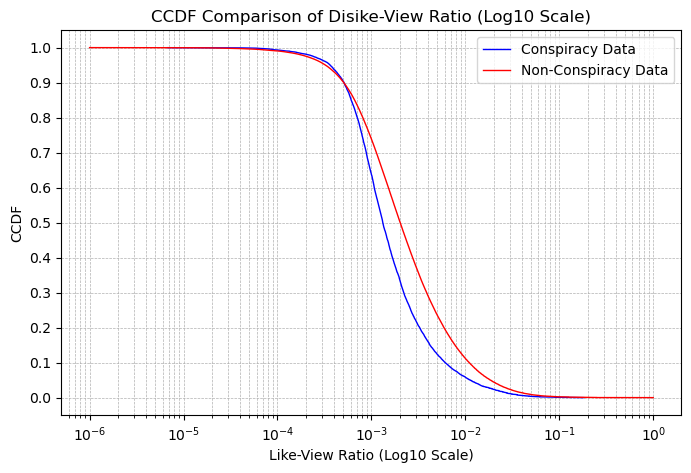

<Figure size 640x480 with 0 Axes>

In [74]:

dislike_view_ratio1 = conspiracy_df['dislike_count'].dropna().replace(0, 0.25) / conspiracy_df['view_count'].dropna().replace(0, 1)
dislike_view_ratio2 = non_conspiracy_df['dislike_count'].dropna().replace(0, 0.25) / non_conspiracy_df['view_count'].dropna().replace(0, 1)
dislike_view_ratio1 = np.clip(dislike_view_ratio1, 1e-6, 1).dropna()
dislike_view_ratio2 = np.clip(dislike_view_ratio2, 1e-6, 1).dropna()

dislike_view_ratio1 = np.sort(dislike_view_ratio1)
dislike_view_ratio2 = np.sort(dislike_view_ratio2)

dislike_view_ratio_cdf1 = 1 - np.arange(1, len(dislike_view_ratio1) + 1) / len(dislike_view_ratio1)
dislike_view_ratio_cdf2 = 1 - np.arange(1, len(dislike_view_ratio2) + 1) / len(dislike_view_ratio2)


# plot CCDF of like-view ratio
plt.figure(figsize=(8, 5))

plt.plot(dislike_view_ratio1, dislike_view_ratio_cdf1, label='Conspiracy Data', linewidth=1, color='blue')
plt.plot(dislike_view_ratio2, dislike_view_ratio_cdf2, label='Non-Conspiracy Data', linewidth=1, color='red')

plt.xscale('log')
plt.title('CCDF Comparison of Disike-View Ratio (Log10 Scale)')
plt.xlabel('Like-View Ratio (Log10 Scale)')
plt.ylabel('CCDF')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()
plt.savefig('dislike_view_ratio_comparison.png', dpi=300)



In [ ]:
from scipy import stats
import numpy as np
# Make sure view_count is not NaN
conspiracy_df['view_count'] = conspiracy_df['view_count'].replace(0, 1)
non_conspiracy_df['view_count'] = non_conspiracy_df['view_count'].replace(0, 1)

conspiracy_view_counts = conspiracy_df['view_count'].dropna()
non_conspiracy_view_counts = non_conspiracy_df['view_count'].dropna()
# Perform Mann-Whitney U test
from scipy.stats import mannwhitneyu

t_stat, p_value_two_sided = mannwhitneyu(conspiracy_view_counts, non_conspiracy_view_counts)

# Convert to one-sided p-value
# We're interested in whether conspiracy videos have *more* views, so we halve the two-sided p-value if t-statistic is positive
if t_stat > 0:
    p_value_one_sided = p_value_two_sided / 2
else:
    p_value_one_sided = 1 - (p_value_two_sided / 2)

print(f"T-statistic: {t_stat}, one-sided p-value: {p_value_one_sided}")

# Interpret the results for one-sided test
if p_value_one_sided < 0.05:
    print("Results are significant: Conspiracy videos have significantly more view counts than non-conspiracy videos.")
elif 1 - p_value_one_sided < 0.05:
    print("Results are significant: Conspiracy videos have significantly less view counts than non-conspiracy videos.")
else:
    print("Results are not significant: No significant evidence that conspiracy videos have more view counts than non-conspiracy videos.")


T-statistic: 2351163165.5, one-sided p-value: 5.6346069368654465e-192
Results are significant: Conspiracy videos have significantly more view counts than non-conspiracy videos.


In [34]:
from scipy import stats
import numpy as np

# Make copies to avoid SettingWithCopyWarning
conspiracy_df = conspiracy_df.copy()
non_conspiracy_df = non_conspiracy_df.copy()


conspiracy_like_count = np.log(conspiracy_df['like_count'].replace(0, 0.1).dropna())
non_conspiracy_like_count = np.log(non_conspiracy_df['like_count'].replace(0, 0.1).dropna())

conspiracy_dislike_count = np.log(conspiracy_df['dislike_count'].replace(0, 0.1).dropna())
non_conspiracy_dislike_count = np.log(non_conspiracy_df['dislike_count'].replace(0, 0.1).dropna())

# perform mannwhitneyu test
if len(conspiracy_like_count.unique()) > 1 and len(non_conspiracy_like_count.unique()) > 1:
    # T-test - Like Count
    t_stat_like, p_value_like = mannwhitneyu(conspiracy_like_count, non_conspiracy_like_count)
    print(f"Like Count - T-statistic: {t_stat_like}, p-value: {p_value_like}")

    if p_value_like < 0.05:
        if t_stat_like > 0:
            print("Conspiracy videos have significantly more likes than non-conspiracy videos.")
        else:
            print("Non-conspiracy videos have significantly more likes than conspiracy videos.")
    else:
        print("No significant difference in like count between conspiracy and non-conspiracy videos.")
else:
    print("Like Count: One or both groups have zero variance, cannot perform t-test.")

if len(conspiracy_dislike_count.unique()) > 1 and len(non_conspiracy_dislike_count.unique()) > 1:
    t_stat_dislike, p_value_dislike = mannwhitneyu(conspiracy_dislike_count, non_conspiracy_dislike_count)
    print(f"\nDislike Count - T-statistic: {t_stat_dislike}, p-value: {p_value_dislike}")

    if p_value_dislike < 0.05:
        if t_stat_dislike > 0:
            print("Conspiracy videos have significantly more dislikes than non-conspiracy videos.")
        else:
            print("Non-conspiracy videos have significantly more dislikes than conspiracy videos.")
    else:
        print("No significant difference in dislike count between conspiracy and non-conspiracy videos.")
else:
    print("Dislike Count: One or both groups have zero variance, cannot perform t-test.")

# Drop missing values (NaN) in like_dislike_rate
conspiracy_like_dislike_rate = conspiracy_df['like_dislike_ratio'].dropna()
non_conspiracy_like_dislike_rate = non_conspiracy_df['like_dislike_ratio'].dropna()
from scipy.stats import mannwhitneyu

t_stat_rate, p_value_rate = mannwhitneyu(conspiracy_view_counts, non_conspiracy_view_counts)
if len(conspiracy_like_dislike_rate.unique()) > 1 and len(non_conspiracy_like_dislike_rate.unique()) > 1:
    print(f"\nLike-Dislike Rate - T-statistic: {t_stat_rate}, p-value: {p_value_rate}")

    if p_value_rate < 0.05:
        if t_stat_rate > 0:
            print("Conspiracy videos have a significantly higher like-dislike ratio than non-conspiracy videos.")
        else:
            print("Non-conspiracy videos have a significantly higher like-dislike ratio than conspiracy videos.")
    else:
        print("No significant difference in the like-dislike ratio between conspiracy and non-conspiracy videos.")
else:
    print("Like-Dislike Rate: One or both groups have zero variance, cannot perform t-test.")


Like Count - T-statistic: 2626975335.0, p-value: 0.0
Conspiracy videos have significantly more likes than non-conspiracy videos.

Dislike Count - T-statistic: 2097074046.0, p-value: 3.151107229671464e-52
Conspiracy videos have significantly more dislikes than non-conspiracy videos.

Like-Dislike Rate - T-statistic: 2351163165.5, p-value: 1.1269213873730893e-191
Conspiracy videos have a significantly higher like-dislike ratio than non-conspiracy videos.


In [47]:
from scipy.stats import ranksums
# perform wilcoxon rank-sum test
stat, p_value = ranksums(like_view_ratio1, like_view_ratio2)
print(f"Wilcoxon Rank-Sum Test - Like-View Ratio: Statistic = {stat}, p-value = {p_value}")
if p_value < 0.01:
    if stat > 0:
        print("Conspiracy videos have a significantly higher Like-View Ratio.")
    else:
        print("Non-Conspiracy videos have a significantly higher Like-View Ratio.")
else:
    print("No significant difference in Like-View Ratio.")

stat2, p_value2 = ranksums(dislike_view_ratio1, dislike_view_ratio2)
print(f"Wilcoxon Rank-Sum Test - Dislike-View Ratio: Statistic = {stat2}, p-value = {p_value2}")
if p_value2 < 0.01:
    if stat2 > 0:
        print("Conspiracy videos have a significantly higher Dislike-View Ratio.")
    else:
        print("Non-Conspiracy videos have a significantly higher Dislike-View Ratio.")
else:
    print("No significant difference in Dislike-View Ratio.")


Wilcoxon Rank-Sum Test - Like-View Ratio: Statistic = 77.81492742957741, p-value = 0.0
Conspiracy videos have a significantly higher Like-View Ratio.
Wilcoxon Rank-Sum Test - Dislike-View Ratio: Statistic = -30.733028694254127, p-value = 2.0614356439212524e-207
Non-Conspiracy videos have a significantly higher Dislike-View Ratio.


In [60]:

conspiracy_df['new_metric'] = (conspiracy_df['like_count'] - 0.5 * conspiracy_df['dislike_count']) / conspiracy_df['view_count']
non_conspiracy_df['new_metric'] = (non_conspiracy_df['like_count'] - 0.5 * non_conspiracy_df['dislike_count']) / non_conspiracy_df['view_count']
print(conspiracy_df['new_metric'].describe())
print(non_conspiracy_df['new_metric'].describe())

# Perform t-test to compare the new_metric between conspiracy and non-conspiracy videos
t_stat, p_value = stats.mannwhitneyu(conspiracy_df['new_metric'].dropna(), non_conspiracy_df['new_metric'].dropna())
print(f"T-statistic: {t_stat}, p-value: {p_value}")
# Interpret the results
if p_value < 0.05:
    if t_stat > 0:
        print("Conspiracy videos have a significantly larger new_metric than non-conspiracy videos.")
    else:
        print("Non-conspiracy videos have a significantly larger new_metric than conspiracy videos.")
else:
    print("No significant difference in new_metric between conspiracy and non-conspiracy videos.")

count   8,854.00
mean        0.05
std         0.04
min        -0.09
25%         0.03
50%         0.05
75%         0.07
max         0.87
Name: new_metric, dtype: float64
count   432,978.00
mean          0.03
std           0.05
min          -6.22
25%           0.01
50%           0.02
75%           0.04
max          21.75
Name: new_metric, dtype: float64
T-statistic: 2842165192.5, p-value: 0.0
Conspiracy videos have a significantly larger new_metric than non-conspiracy videos.


: 